## South Africa looks like...
How does the growth of COVID-19 new cases in South Africa compare with other countries?<br>
(c) 2020, [Thomas Wiecki](https://twitter.com/twiecki)<br>
Adapted for South Africa by [Alta de Waal](https://twitter.com/AltadeWaal) 

This notebook gets up-to-date data from the [Coronavirus COVID-19 (2019-nCoV) Data Repository for South Africa [Hosted by DSFSI group at University of Pretoria]](https://github.com/dsfsi/covid19za) and recreates the plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441).


### Prepare the environment:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

### Load the data
1. Data is downloaded directly from the CCSE repo.

In [4]:
def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df,
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

df_confirmed = load_timeseries('Confirmed')

# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

#We want to compute days relative to when n (say 100) confirmed cases was crossed.
#In the early stages n is 1
n = 1
# Compute days relative to when n confirmed cases was crossed
df_confirmed.loc[:, 'days_since_n'] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_n'] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < n)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= n)]))
    
annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Alta de Waal (adapted from https://github.com/twiecki/covid19/blob/master/covid19_growth.ipynb)'.format(df_confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

C:\Users\u20285826\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
print(df_confirmed.country.unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

In [6]:
#Choose the country group and countries you want to include.
#The reason for different country groups is that it displays in different line types

#european_countries = ['Italy', 'Spain', 'United Kingdom (total)','Iran']
#large_engl_countries = ['Australia (total)','US (total)']#, 'Canada (total)', 'Australia (total)']
#asian_countries = ['Singapore']#, 'Japan', 'Korea, South', 'Hong Kong']
#south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

sub_saharan = ['Angola','Benin','Botswana','Burkina Faso','Burundi', 'Cabo Verde', 'Nigeria', 'Mozamibue','Congo (Brazzaville)',
              'Central African Republic', 'Senegal', 'Ghana','Kenya','Rwanda','Ethiopia', 'Sudan']
african_countries = ['Morocco' , 'Egypt']
south_africa = ['South Africa']

country_groups = [sub_saharan, african_countries, south_africa]
line_styles = ['-', ':', '--', '-.', '-']

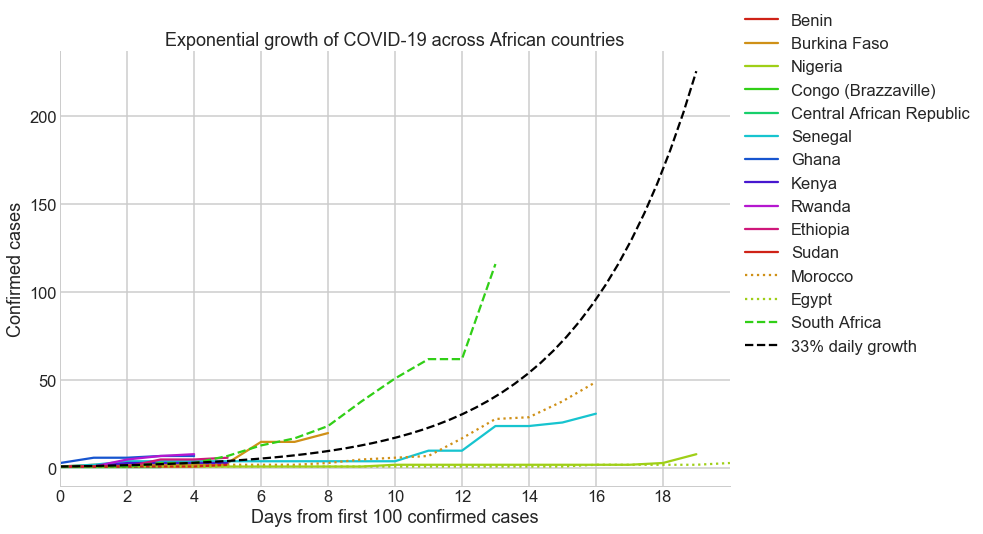

In [9]:

def plot_countries(df, countries, min_cases=n, xmax = 20,  ls='-', col='cases'):
    for country in countries:
        df_country = df.loc[(df.country == country) & (df.cases >= min_cases)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(xlim = (0,xmax), label=country, ls=ls)
        
sns.set_palette(sns.hls_palette(10, l=.45, s=.8)) # 10 countries max
fig, ax = plt.subplots(figsize=(12, 8))

#for the exponential growth, limit the xmax value, otherwise the early growth is not possible.
for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, xmax = 20, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, n * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(title='Exponential growth of COVID-19 across African countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases')
ax.set_xticks(np.arange(min(x), max(x)+2, 2.0))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 0.27))
#ax.annotate(**annotate_kwargs)
sns.despine();

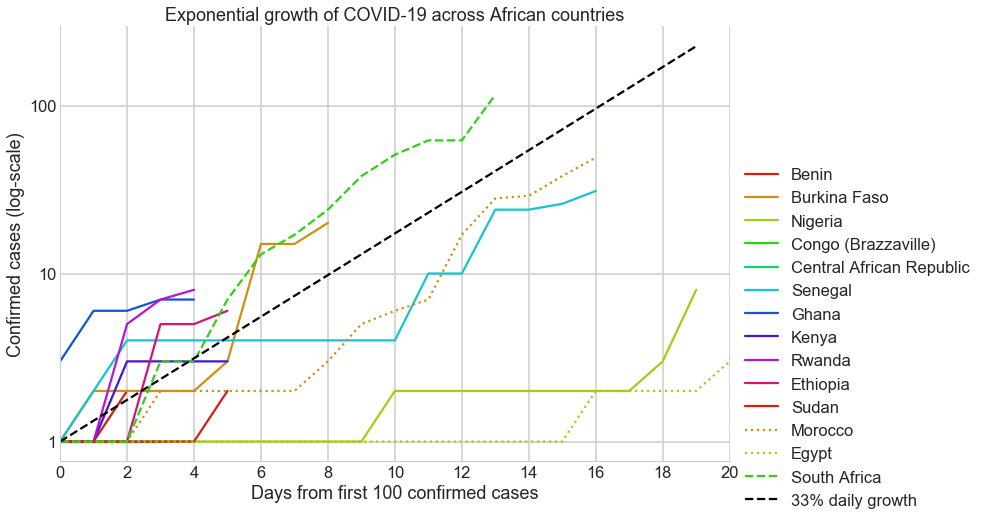

In [10]:
        
sns.set_palette(sns.hls_palette(10, l=.45, s=.8)) # 10 countries max
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, n * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(yscale='log',
       title='Exponential growth of COVID-19 across African countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases (log-scale)')
ax.set_xticks(np.arange(min(x), max(x)+2, 2.0))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 0.71))
#ax.annotate(**annotate_kwargs)
sns.despine();